## Import

In [ ]:
# main lib
import os
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

## Data preparation

In [187]:
DATASET_DIR = '/kaggle/input/google-speech-commands'
CLASSES = ['zero', 'one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine']
os.chdir(DATASET_DIR)

In [ ]:
# Check if there is imbalanced data.
for class_ in CLASSES:
    class_dir = os.path.join(DATASET_DIR, class_)
    print(f"num of {class_}:" ,len(os.listdir(class_dir)))

num of zero: 2376
num of one: 2370
num of two: 2373
num of three: 2356
num of four: 2372
num of five: 2357
num of six: 2369
num of seven: 2377
num of eight: 2352
num of nine: 2364


### Feature extraction from wav files 

In [ ]:
def feature_extraction(class_dir_name: str, n_mfcc=40, max_len=100):
    class_dir_path = os.path.join(DATASET_DIR, class_dir_name)
    all_mfccs = []
    
    for file_name in os.listdir(class_dir_path):
        if file_name.endswith(".wav"):
            # Construct the full path to the audio file
            audio_file_path = os.path.join(class_dir_path, file_name)
            
            try:
                # Load the audio file using Librosa
                librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)
                
                # Compute MFCCs for the audio file
                mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=n_mfcc)
                
                # Padding or trimming the MFCCs to a fixed length
                if mfccs.shape[1] < max_len:
                    pad_width = max_len - mfccs.shape[1]
                    mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfccs = mfccs[:, :max_len]
                
                # Append the MFCCs to the list
                all_mfccs.append(mfccs)
            except Exception as e:
                print(f"Could not process {audio_file_path}: {e}")
    
    # Convert to numpy array
    all_mfccs = np.array(all_mfccs)

    return all_mfccs


In [190]:
# Extract features for all classes and store in a DataFrame
X = []
y = []
for class_name in CLASSES:
    mfccs = feature_extraction(class_name)
    for mfcc in mfccs:
        # Flatten the MFCC array to make it compatible with a DataFrame
        flattened_mfcc = mfcc.reshape(-1, mfccs.shape[1] * mfccs.shape[2])
        # Append to the data list with the label
        X.append(flattened_mfcc)
        y.append(class_name)



In [191]:
X_arr = np.array(X)
X_arr = X_arr.reshape(-1, 4000) 
y_arr = np.array(y)

In [192]:
print(f"X_arr shape: {X_arr.shape}")
print(f"y_arr shape: {y_arr.shape}")


X_arr shape: (23666, 4000)
y_arr shape: (23666,)


In [ ]:
# Convert to a DataFrame
df = pd.DataFrame({'features': X, 'label': y_arr})

df

,features,label
0,"[[-472.28897, -463.65152, -451.6498, -444.5827...",zero
1,"[[-544.9385, -529.7211, -526.4188, -516.7711, ...",zero
2,"[[-737.0905, -737.0905, -735.9269, -694.17883,...",zero
3,"[[-579.6466, -579.5267, -579.4192, -579.51373,...",zero
4,"[[-506.4717, -559.8293, -666.92035, -671.29584...",zero
...,...,...
23661,"[[-655.30237, -655.30237, -655.30237, -655.302...",nine
23662,"[[-492.07175, -471.46387, -464.61188, -471.423...",nine
23663,"[[-500.85974, -474.5257, -484.3618, -489.2825,...",nine
23664,"[[-588.3303, -499.71283, -451.2705, -433.97366...",nine


### Encoding target

In [194]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data to one-hot encoding
y_encoded = encoder.fit_transform(y_arr.reshape(-1, 1))
y_encoded

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [195]:
y_encoded.shape

(23666, 10)

### Split the data


In [248]:
X_train, X_test, y_train, y_test = train_test_split(X_arr ,y_encoded ,test_size=0.2, stratify=y_encoded, random_state=45)

In [249]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (18932, 4000)
X_test shape: (4734, 4000)
y_train shape: (18932, 10)
y_test shape: (4734, 10)


## Model

- BatchNormalization() layer is added as the first layer to normalize the input data.

In [250]:
model = Sequential([
    BatchNormalization(),
    Dense(1024, input_shape=(4000,), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [251]:
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_77          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [252]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00002), metrics=['accuracy'])


In [253]:
X_train[0]

array([-758.38916, -739.48694, -735.74286, ...,    0.     ,    0.     ,
          0.     ], dtype=float32)

## Training model

In [258]:
batch_size = 64
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/audio_classification.keras',verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks = [early_stopping, checkpointer], batch_size=batch_size)

Epoch 1/200
233/237 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9159 - loss: 0.2636
Epoch 1: val_loss improved from inf to 0.52768, saving model to /kaggle/working/audio_classification.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9159 - loss: 0.2636 - val_accuracy: 0.8490 - val_loss: 0.5277
Epoch 2/200
232/237 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9161 - loss: 0.2611
Epoch 2: val_loss improved from 0.52768 to 0.52586, saving model to /kaggle/working/audio_classification.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9161 - loss: 0.2612 - val_accuracy: 0.8503 - val_loss: 0.5259
Epoch 3/200
224/237 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9237 - loss: 0.2372
Epoch 3: val_loss improved from 0.52586 to 0.52428, saving model to /kaggle/working/audio_classification.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9233 - loss: 0.2379 - val_accuracy: 0.8516 - val_loss: 0.5243
Epoch 4/200
224/237 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

In [259]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8489 - loss: 0.5185
Test Accuracy: 85.30%
Test Loss: 0.5141


## visualization

### Learning curves

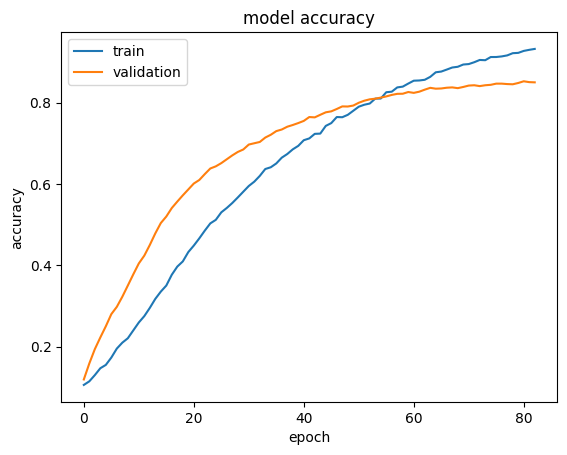

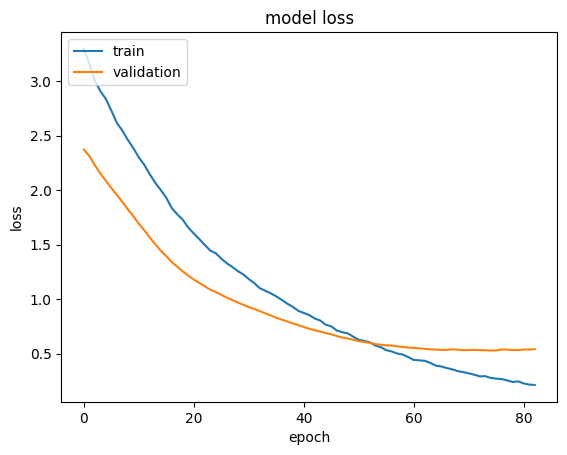

In [256]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion matrix

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


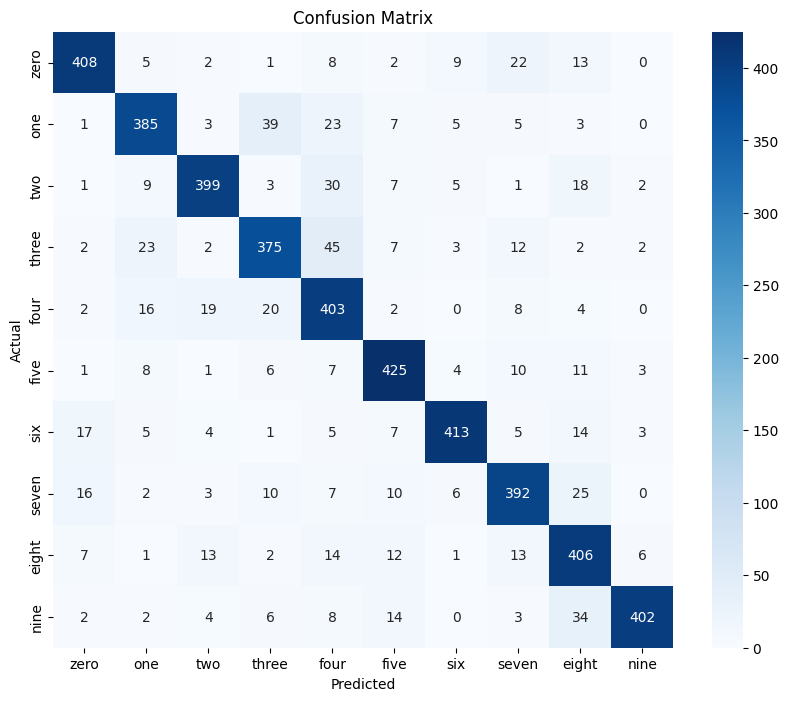

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Done!